In [1]:
# these are some necessary libs, but feel free to import whatever you need
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
import math

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls "/content/drive/MyDrive/Colab Notebooks"

24789_HW3.zip	     burgers_test.npy	HW4_24788_Spring_24_Final.ipynb  pde_gpt.ipynb	unet.py
24789-HW4-S24-1.zip  burgers_train.npy	MNIST_Diffusion.ipynb		 __pycache__


In [4]:
!unzip -q "/content/drive/MyDrive/Colab Notebooks/24789-HW4-S24-1.zip"

In [5]:
### don't change this
### seed everything for reproducibility
def seed_everything():
    seed = 42
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# 2. Prepare for the Transformer

### 2(a) Implement a scaled dot product

In [6]:
def scaled_dot_product(q, k, v):
    d_k = q.size()[-1]

    # TODO: put your code below
    # values should be the final output
    # attention should be the n by n attention matrix (the dot product after softmax)

    out = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k).float())
    attention = F.softmax(out, dim=1)
    values = torch.matmul(attention, v)

    #========================#
    return values, attention

In [7]:
### set what you get
### do not modify this cell
seed_everything()
seq_len, d_k = 3, 2
q = torch.randn(seq_len, d_k)
k = torch.randn(seq_len, d_k)
v = torch.randn(seq_len, d_k)
values, attention = scaled_dot_product(q, k, v)
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attention)
assert attention.shape == (seq_len, seq_len)

Q
 tensor([[ 0.3367,  0.1288],
        [ 0.2345,  0.2303],
        [-1.1229, -0.1863]])
K
 tensor([[ 2.2082, -0.6380],
        [ 0.4617,  0.2674],
        [ 0.5349,  0.8094]])
V
 tensor([[ 1.1103, -1.6898],
        [-0.9890,  0.9580],
        [ 1.3221,  0.8172]])
Values
 tensor([[ 0.5698, -0.1520],
        [ 0.5379, -0.0265],
        [ 0.2246,  0.5556]])
Attention
 tensor([[0.4028, 0.2886, 0.3086],
        [0.3538, 0.3069, 0.3393],
        [0.1303, 0.4630, 0.4067]])


### 2(b) Try masked scaled-dot product

In [8]:
def masked_scaled_dot_product(q, k, v, mask):
    # the mask will be in shape n by n, it indicates the interaction between specific pair of tokens need not be considered
    d_k = q.size()[-1]

    # TODO: put your code below
    # values should be the final output
    # attention should be the n by n attention matrix (the dot product after softmax)

    out = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k).float())
    out = out.masked_fill(mask == 0, float('-inf'))
    attention = F.softmax(out, dim=1)
    values = torch.matmul(attention, v)

    #========================#
    return values, attention

In [9]:
### set what you get
### do not modify this cell
seed_everything()
seq_len, d_k = 3, 2
# create a low triangular mask
# looks like this
# 1 0 0
# 1 1 0
# 1 1 1
# this will also be helpful for masked attention in the decoder
mask = torch.tril(torch.ones(seq_len, seq_len)) == 0
q = torch.randn(seq_len, d_k)
k = torch.randn(seq_len, d_k)
v = torch.randn(seq_len, d_k)
values, attention = masked_scaled_dot_product(q, k, v, mask)
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attention)

Q
 tensor([[ 0.3367,  0.1288],
        [ 0.2345,  0.2303],
        [-1.1229, -0.1863]])
K
 tensor([[ 2.2082, -0.6380],
        [ 0.4617,  0.2674],
        [ 0.5349,  0.8094]])
V
 tensor([[ 1.1103, -1.6898],
        [-0.9890,  0.9580],
        [ 1.3221,  0.8172]])
Values
 tensor([[0.2052, 0.8852],
        [1.3221, 0.8172],
        [   nan,    nan]])
Attention
 tensor([[0.0000, 0.4833, 0.5167],
        [0.0000, 0.0000, 1.0000],
        [   nan,    nan,    nan]])


### 2(c) Positional encoding (from original Transformer)

In [27]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)

        # ==================================== #
        # TODO: put your code below

        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # ==================================== #
        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        pe = self.pe[:x.size(1), :]

        #TODO: put your code below
        # print(x.shape)
        # print(pe.shape)
        x = x+pe

        return x

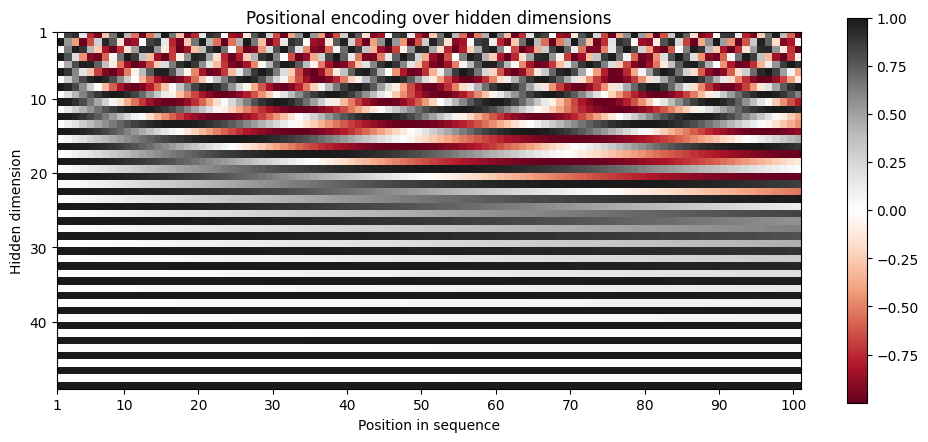

In [25]:
### visualize the positional encoding and see what you get, do not modify this

pe_block = PositionalEncoding(d_model=48, max_len=100)
pe = pe_block.pe.squeeze().T.cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))
pos = ax.imshow(pe, cmap="RdGy", extent=(1,pe.shape[1]+1,pe.shape[0]+1,1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1]+[i*10 for i in range(1,1+pe.shape[1]//10)])
ax.set_yticks([1]+[i*10 for i in range(1,1+pe.shape[0]//10)])
plt.show()

# 3. Build your own "GPT" for 1D Burgers' prediction

In [12]:
### load data, modify this when you have a different path
train_data = np.load('/content/drive/MyDrive/Colab Notebooks/burgers_train.npy')
test_data = np.load('/content/drive/MyDrive/Colab Notebooks/burgers_test.npy')
print(train_data.shape, test_data.shape)

(2048, 40, 100) (128, 40, 100)


### Visualize a sequence (optional)

In [13]:
### You don't have to modify this function
from matplotlib.ticker import FormatStrFormatter

def show_field(field):

    fig, ax = plt.subplots(figsize=(15, 5))
    # mark y axis as time, x axis as space
    ax.set_xlabel('x',fontsize=16)
    ax.set_ylabel('t', fontsize=16)
    ax.set_xlim(0, 50+1e-5)

    ax.set_yticks(np.arange(0, 41, 10), [str(round(f, 2)) for f in np.linspace(0, 1.28, 5)][::-1])
    ax.set_xticks(np.arange(0, 101, 10),[str(round(f, 2)) for f in np.linspace(0, 16, 11)])

    im = ax.imshow(field,cmap='seismic')
    plt.colorbar(im)

    plt.show()

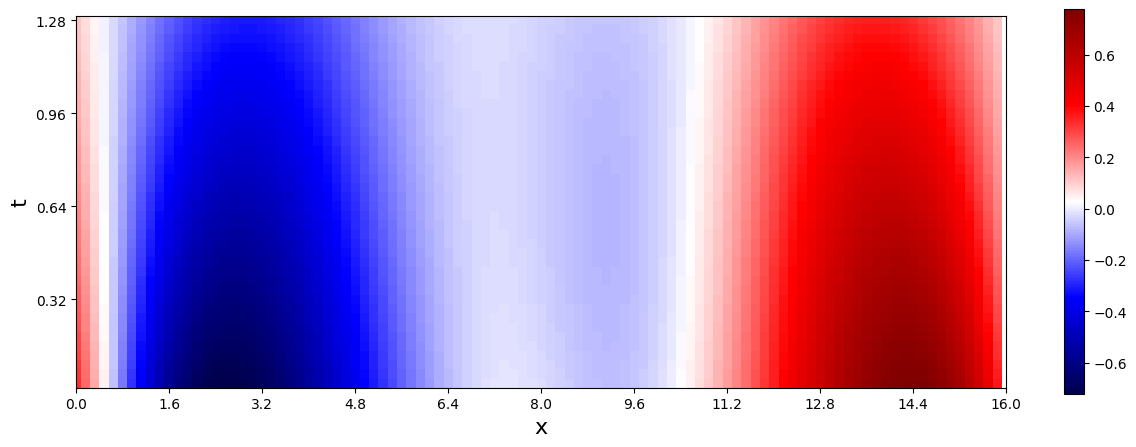

In [14]:
show_field(train_data[0])

Text(0, 0.5, 'u')

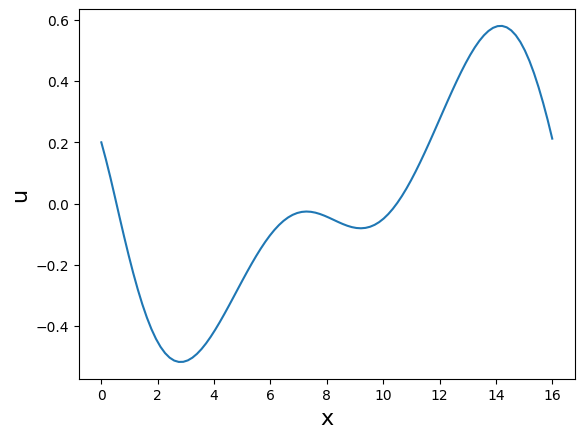

In [15]:
# take a look at one of the snapshots
plt.plot(np.linspace(0, 16, 100), train_data[0, 20])
plt.gca().set_xlabel('x',fontsize=16)
plt.gca().set_ylabel('u', fontsize=16)

#### Helper functions (do not modify!)

In [16]:
### do not modify this cell
### ======================
class SimpleEncoder(nn.Module):
    # for embedding the first 10 time steps of darcy flow
    def __init__(self,
                 input_dim=100,    # we take number of grid points as number of feature for each frame
                 hidden_dim=64,   # hidden dimensionality of the encoder
                 emb_dim=128):
        super().__init__()
        # we use 1d depth-wise convolution to embed the input
        self.net = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim, kernel_size=1, stride=1, padding=0, groups=4),
            nn.GELU(),   # GELU is a better version of ReLU, for most tasks
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=1, stride=1, padding=0, groups=8),
            nn.GELU(),
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=1, stride=1, padding=0, groups=4),
            nn.GELU(),
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=1, stride=1, padding=0),
            nn.GELU(),
            nn.Conv1d(hidden_dim, emb_dim, kernel_size=1, stride=1, padding=0))

        self.to_out = nn.Sequential(
            nn.LayerNorm(emb_dim),
            nn.Linear(emb_dim, emb_dim),
        )

    def forward(self, x):
        # x will be in shape [b t n], n is number of grid points, but you can think it as feature dimension
        # we need to transpose it to [b n t] for the convolution
        x = x.transpose(1, 2)
        # now we can apply the convolution
        x = self.net(x)
        x = x.transpose(1, 2)
        return self.to_out(x)


class SimpleDecoder(nn.Module):
    # go back from the latent space to the physical space
    def __init__(self,
                 input_dim=128,     # latent dimensionality
                 hidden_dim=64,   # hidden dimensionality of the decoder
                 output_dim=100):
        super().__init__()
        self.ln = nn.LayerNorm(input_dim)
        self.net = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim, kernel_size=1, stride=1, padding=0),
            nn.GELU(),
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=1, stride=1, padding=0, groups=4),
            nn.GELU(),
            nn.Conv1d(hidden_dim, output_dim, kernel_size=1, stride=1, padding=0, groups=2),
        )

    def forward(self, x):
        # x will be in shape [b t c]
        x = self.ln(x)
        x = x.transpose(1, 2)
        x =  self.net(x).transpose(1, 2)  # [b t c] again
        return x



class FFN(nn.Module):
    # give to you for free, need to be used in the transformer
    def __init__(self, input_dim=128, hidden_dim=128, output_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(input_dim),
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        return self.net(x)

### Implement a multi-head self-attention module (with causal mask)

In [17]:
# you need to implement this
class CausalSelfAttention(nn.Module):

    def __init__(self,
                 dim,
                 dim_head,
                 num_heads,
                 dropout,       # dropout for attention matrix (Q^T K), not input or output
                 max_len=50
                 ):
        super().__init__()
        self.dim = dim
        self.inner_dim = dim_head * num_heads
        self.num_heads = num_heads
        self.dim_head = dim_head

        # ==================================================================
        #TODO: implement the module of the causal self attention

        self.query = nn.Linear(dim,self.inner_dim)
        self.key = nn.Linear(dim,self.inner_dim)
        self.value = nn.Linear(dim,self.inner_dim)

        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(self.inner_dim,dim)

        # ==================================================================
        self._init_weights()

    def _init_weights(self):
        # you can implement some weight initialization here (optional), can provide some performance boost when doing it correctly
        pass

    def forward(self, x):
        # input is in shape [b t c], output is also in shape [b t c]
        B, L, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # ==================================================================
        #TODO: implement the forward pass of the causal self attention

        queries = self.query(x).view(B, L, self.num_heads, self.dim_head).transpose(1, 2)  # [B, num_heads, L, dim_head]
        keys = self.key(x).view(B, L, self.num_heads, self.dim_head).transpose(1, 2)  # [B, num_heads, L, dim_head]
        values = self.value(x).view(B, L, self.num_heads, self.dim_head).transpose(1, 2)  # [B, num_heads, L, dim_head]

        scores = torch.matmul(queries, keys.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.dim_head).float())  # [B, num_heads, L, L]

        # Apply causal mask
        causal_mask = torch.tril(torch.ones(L, L)).view(1, 1, L, L).to(scores.device)
        scores = scores.masked_fill(causal_mask == 0, float('-inf'))

        # Apply softmax to get attention weights
        attention_weights = F.softmax(scores, dim=-1)  # [B, num_heads, L, L]

        # Apply dropout
        attention_weights = self.dropout(attention_weights)

        # Weighted sum of values
        attention_output = torch.matmul(attention_weights, values)  # [B, num_heads, L, dim_head]

        # Concatenate attention outputs from all heads and project back to the original dimension
        attention_output = attention_output.transpose(1, 2).contiguous().view(B, L, self.inner_dim)
        output = self.out(attention_output)  # [B, L, dim]

        return output

### Use above attention block to build a PDE-GPT

In [18]:
### you only have to fill a small part inside the forward function
class PDEGPT(nn.Module):
    def __init__(self,
                 num_layers,    # the only hyperparameter to play with, could start with sth like 6
                 ):
        super().__init__()

        self.transformer = nn.ModuleList([])
        for _ in range(num_layers):
            self.transformer.append(nn.ModuleList([
                nn.LayerNorm(128),
                CausalSelfAttention(dim=128, dim_head=128, num_heads=4, dropout=0.05),
                FFN(input_dim=128, hidden_dim=128, output_dim=128),
            ]))
        self.function_encoder = SimpleEncoder()
        self.function_decoder = SimpleDecoder()
        self.position_embedding =  PositionalEncoding(128, 40)

        # report number of parameters
        print(f"Total number of trainable parameters: {self.get_num_params()}" )

    def get_num_params(self):
        n_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        return n_params

    def forward(self, seq, noise=True, tstart=0):
        # seq in shape [batch_size, 49, 100] t=49, n=100, think about why it is 49 not 50

        b, t, n = seq.size()
        device = seq.device

        # forward the GPT model itself
        if noise:
            # add random walk noise to the input
            seq = seq + torch.cumsum(torch.randn_like(seq) * 0.003, dim=1)
        x = self.function_encoder(seq)   # [b t n] -> [b t c]
        x = x + self.position_embedding(x) # add position embedding

        for ln, attn_block, ffn in self.transformer:
            # ln: layer normalization
            # attn_block: self attention layer
            # ffn: feed forward network (a two-layer MLP)
            # ===================================================
            # TODO: implement one forward pass of the transformer (do not modify other part of this class)

            x = ln(x+attn_block(x))
            x = ln(x+ffn(x))


            # ===================================================

        x = self.function_decoder(x)   # [b t c] -> [b t n]

        return x

    def predict(self, in_seq, predict_steps=30, tstart=0):
        # in_seq will be in shape [batch_size, 10, 100]
        out_seq = torch.zeros(in_seq.size(0), predict_steps, in_seq.size(2)).to(in_seq.device)
        for t in range(predict_steps):
            if self.training:
                shifted_in_seq = self.forward(in_seq, noise=True, tstart=tstart)
            else:
                shifted_in_seq = self.forward(in_seq, noise=False, tstart=tstart)
            in_seq = torch.cat((in_seq, shifted_in_seq[:, -1:]), dim=1)
            out_seq[:, t:t+1] = shifted_in_seq[:, -1:]

        return out_seq

### Train the model

In [19]:
### do not modify this cell!
### ==============================
def train_a_gpt(lr,
                num_layers,
                batch_size,
                num_epochs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('Using device:', device)
    # train a GPT model with num_layers
    model = PDEGPT(num_layers=num_layers)
    model = model.to(device)

    # build dataloader
    train_set = torch.utils.data.TensorDataset(torch.tensor(train_data, dtype=torch.float32))
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)

    test_set = torch.utils.data.TensorDataset(torch.tensor(test_data, dtype=torch.float32))
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=False, num_workers=4)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, total_steps=num_epochs*len(train_loader), final_div_factor=1e3)

    train_history = []
    test_history = []
    loss_buffer = []
    for epoch in range(num_epochs):
        model.train()
        for i, seq in enumerate(train_loader):
            seq = seq[0].to(device)
            optimizer.zero_grad()
            # training in block, not always using teacher forcing
            if i % 3 == 0:
                loss = 0
                ct = 0
                for b in range(0, seq.size(1)-20, 10):
                    pred = model.predict(seq[:, b:b+10], predict_steps=10, tstart=b)
                    loss += F.mse_loss(pred, seq[:, b+10:b+20])
                    ct += 1
                loss /= ct
            else:
                pred = model(seq[:, :-1])
                loss = F.mse_loss(pred, seq[:, 1:])
            loss.backward()
            optimizer.step()
            loss_buffer.append(loss.item())

            if i % 20 == 0:
                print("epoch %d, iter %d, loss %.3f" % (epoch, i, np.mean(loss_buffer)))
                loss_buffer = []
        train_history.append(loss.item())
        scheduler.step()

        model.eval()
        test_losses = []
        with torch.no_grad():
            for i, seq in enumerate(test_loader):
                seq = seq[0].to(device)
                pred = model.predict(seq[:, :10])
                loss = F.mse_loss(pred, seq[:, 10:])

                test_losses.append(loss.item())
        print("epoch %d, test loss %.3f" % (epoch, np.mean(test_losses)))
        test_history.append(np.mean(test_losses))

    return model, train_history, test_history


def eval_and_visualize(trained_model):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('Using device:', device)
    test_set = torch.utils.data.TensorDataset(torch.tensor(test_data, dtype=torch.float32))
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=False, num_workers=4)

    trained_model.eval()
    test_losses = []
    with torch.no_grad():
        for i, seq in enumerate(test_loader):
            seq = seq[0].to(device)
            pred = trained_model.predict(seq[:, :10])
            loss = F.mse_loss(pred, seq[:, 10:])

            test_losses.append(loss.item())

        print('Final evaluation error:', np.mean(test_losses))

        # randomly pick a sample to evaluate and visualize
        seed_everything()
        idx = np.random.randint(0, len(test_data))
        seq = torch.tensor(test_data[idx:idx+1], dtype=torch.float32).to(device)
        pred = trained_model.predict(seq[:, :10])
        pred_seq = torch.cat((seq[:, :10], pred), dim=1).cpu().numpy()[0]

        plt.plot(np.linspace(0, 16, 100), seq.cpu().numpy()[0, -1], label='ground truth')
        plt.scatter(np.linspace(0, 16, 100), pred_seq[-1], label='prediction', c='g')
        plt.legend()
        plt.show()

    return

Using device: cuda:0
Total number of trainable parameters: 1829540
epoch 0, iter 0, loss 0.635
epoch 0, iter 20, loss 0.548
epoch 0, iter 40, loss 0.557
epoch 0, iter 60, loss 0.560
epoch 0, test loss 0.641
epoch 1, iter 0, loss 0.527
epoch 1, iter 20, loss 0.546
epoch 1, iter 40, loss 0.556
epoch 1, iter 60, loss 0.535
epoch 1, test loss 0.616
epoch 2, iter 0, loss 0.561
epoch 2, iter 20, loss 0.529
epoch 2, iter 40, loss 0.508
epoch 2, iter 60, loss 0.497
epoch 2, test loss 0.572
epoch 3, iter 0, loss 0.483
epoch 3, iter 20, loss 0.470
epoch 3, iter 40, loss 0.489
epoch 3, iter 60, loss 0.447
epoch 3, test loss 0.527
epoch 4, iter 0, loss 0.453
epoch 4, iter 20, loss 0.452
epoch 4, iter 40, loss 0.439
epoch 4, iter 60, loss 0.414
epoch 4, test loss 0.490
epoch 5, iter 0, loss 0.397
epoch 5, iter 20, loss 0.418
epoch 5, iter 40, loss 0.388
epoch 5, iter 60, loss 0.388
epoch 5, test loss 0.453
epoch 6, iter 0, loss 0.432
epoch 6, iter 20, loss 0.369
epoch 6, iter 40, loss 0.352
epoch 6

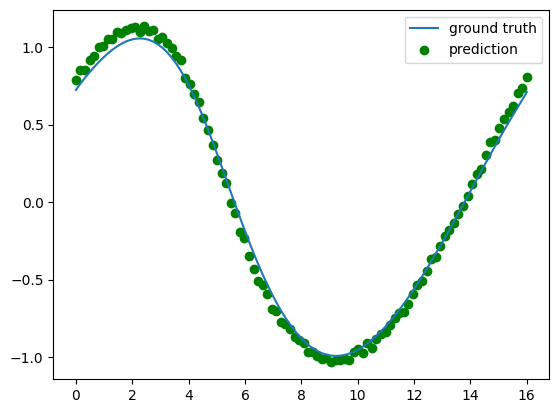

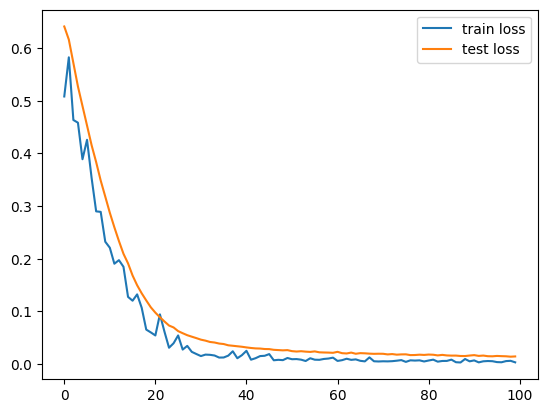

In [28]:
### you can change the hyperparameter of "train_a_gpt" to see how it affects the performance, please do not modify the other parts
### ==============================

torch.cuda.empty_cache()
# change the parameters to see how it affects the performance
model, train_history, test_history = train_a_gpt(lr=1e-3, num_layers=6, batch_size=32, num_epochs=100)
eval_and_visualize(model)

plt.plot(train_history, label='train loss')  # simply visualize the training loss
plt.plot(test_history, label='test loss')
plt.legend()